### Coursework 2

In this coursework you will be aiming to complete two classification tasks. 
Both the classification tasks relate to text classification tasks. 

One task is to be solved using Support Vector Machines. The other has to be solved using Boosting.

The specific tasks and the marking for the various tasks are provided in the notebook. Each task is expected to be accompanied by a lab-report. Each task can have a concise lab report that is maximum of one page in an A4 size. You will be expected to submit your Jupyter Notebook and all lab reports as a single zip file. You could have additional functions implemented that you require for carrying out each task.


#### Task 1

In this task, you need to obtain sentiment analysis for the provided dataset. The dataset consists of movie reviews with the sentiments being provided. The sentiments are either positive or negative. You need to train an SVM based classifier to obtain train and check on the sample test dataset provided. The method will be evaluated also against an external test set. Please do not hardcode any dimensions or number of samples while writing the code. It should be possible to automate the testing and hardcoding values does not allow for automated testing. 

You are allowed to use scikit-learn to implement the SVM. However, you are expected to write your own kernels.

You are allowed to use the existing library functions such as scikit-learn or numpy for obtaining the SVM. The main idea is to analyse the dataset using different kind of kernels. You are also supposed to write your own custom text kernels. Refer to the documentation provided [here](https://scikit-learn.org/stable/modules/svm.html) at 1.4.6.2 and an example [here](https://scikit-learn.org/stable/auto_examples/svm/plot_custom_kernel.html) for writing your own kernels.

Details regarding the marking have been provided in the coursework specification file. Ensure that the code can be run with different test files. 

# 1. Training and testing BoWs extraction

#### Process the text and obtain a bag of words-based features 

In [1]:
!pip3 install textblob
!pip3 install gensim
!pip3 install testfixtures
!pip3 install negspacy
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

  Using cached negspacy-1.0.2.tar.gz (11 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\lolon\\anaconda3\\lib\\site-packages\\spacy-3.2.4.dist-info\\METADATA'



     --------------------------------------- 12.0/12.0 MB 22.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\lolon\\anaconda3\\lib\\site-packages\\spacy-3.2.4.dist-info\\METADATA'



In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from nltk.util import ngrams
from nltk import FreqDist
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import unidecode
import spacy
import en_core_web_sm
import contractions
import string
from tqdm.notebook import tqdm # for showing progress bar
from sklearn.model_selection import GridSearchCV
from textblob import TextBlob
from collections import defaultdict
from datetime import datetime
start = datetime.now()

nltk.download('stopwords')

# initialization
pattern = re.compile(r"(.)\1{2,}")
punc_translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
num_translator = str.maketrans(string.digits, ' ' * len(string.digits))
nlp = en_core_web_sm.load()
stopwords = stopwords.words('english')
custom_negation = ['rather', 'instead']
    
def pre_processing(dataset):
    
    to_return = []
    
    for i in tqdm(range(len(dataset))):
        filtered_data = []
        
        # (1) remove html tags
        dataset[i] = BeautifulSoup(dataset[i]).get_text()
        
        # (2) remove urls
        dataset[i] = re.sub(r'http\S+', '', dataset[i])
        dataset[i] = re.sub(r'www\S+', '', dataset[i])
        
        # (3) remove email addresses
        dataset[i] = re.sub(r'\S*@\S*\s?', '', dataset[i])
        
        # (3) convert to lower case
        dataset[i] = dataset[i].casefold()
        
        # (4) convert accented character
        dataset[i] = unidecode.unidecode(dataset[i]) 
        
        # (5) if there are >2 consecutive duplicated characters, convert to 2 consecutive duplicated characters
        # e.g. finallllly --> finally
        dataset[i] = pattern.sub(r"\1\1", dataset[i]) 
        
        # (6) expand contractions
        dataset[i] = contractions.fix(dataset[i])
        
        # (7) replace punctuation with space
        dataset[i] = dataset[i].translate(punc_translator)
        
        # (8) replace numbers with space
        dataset[i] = dataset[i].translate(num_translator)
        
        # (9) spacy tokenization
        tokens = nlp(dataset[i])
            
        for token in tokens:
            
            # Lemmatisation
            word = token.lemma_
            
            # filter out words that are:
            # - stopwords
            # - with length <= 2
            # - demonstratives (e.g. this, that, those)
            # - pronoun and proper nouns (e.g. names)
            # - spaces
            
            names = [ent.text for ent in tokens if ent.ent_type_]
            
            if (word != "-PRON-") and (word !="-PROPN-") and (word not in names) and (not token.is_space):
               
                #print(word)

                if (token.dep_ == 'neg') or (word in custom_negation):
                    filtered_data.append('_NEG_')
                    continue
                
                # remove the word "like" when it is used as preposition
                if (word == 'like' and token.dep_ == 'prep'):
                    continue
                
                # remove stopwords
                if (word in stopwords):
                    continue

                # remove words with len <= 2
                elif (len(word) <= 2):
                    continue

                else:
                    filtered_data.append(word)
        
        # join words
        filtered_data = ' '.join(filtered_data)
        
        # Negation tagging
        filtered_data = re.sub(r'_NEG_\s', '_NEG_', filtered_data)
        filtered_data = re.sub(r"(_NEG_)\1{1,}", '_NEG_', filtered_data) # remove duplicated negation tagging
        
        to_return.append(filtered_data)
        
    return to_return

def extract_bag_of_words_train_test(train_file, test_file):
    
    # Read the CSV files for training and test sets
    train = pd.read_csv(train_file)
    test = pd.read_csv(test_file)
    
    X_train = np.array(train.review)
    X_test = np.array(test.review)
    
    y_train = np.array(train.sentiment)
    y_train[y_train=='positive'] = 1
    y_train[y_train=='negative'] = -1
    y_train = y_train.astype('int')
    
    y_test = np.array(test.sentiment)
    y_test[y_test=='positive'] = 1
    y_test[y_test=='negative'] = -1
    y_test = y_test.astype('int')
    
    # Extract bag of words features
    print("Train set: ")
    print("Preprocessing progress: ")
    X_train = pre_processing(X_train) 
    print("--Done--\n")
    print("Test set: ")
    print("Preprocessing progress: ")
    X_test = pre_processing(X_test)
    print('--Done--')
    
    return (X_train,y_train,X_test,y_test)

C:\Users\lolon\anaconda3\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lolon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Exploratory analysis
Visualising the distribution of positive and negative reviews in the training and testing sets respectively.

C:\Users\lolon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


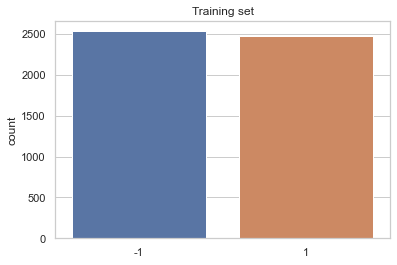

In [46]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.countplot(Y_train).set(title='Training set')

pd.options.display.float_format = "{:,.2f}".format

C:\Users\lolon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Testing set')]

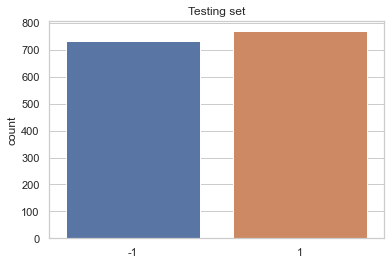

In [47]:
sns.countplot(Y_test).set(title='Testing set')

### Task 2

In this task you need to implement a boosting based classifier that can be used to classify the images. 

Details regarding the marking for the coursework are provided in the coursework specification file. Please ensure that your code will work with a different test file than the one provided with the coursework.

Note that the boosting classifier you implement can include decision trees from scikit-learn or your own decision trees. Use the same sentiment analysis dataset for evaluation.

# 3: Boosting classifier

In [4]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

class BoostingClassifier:
    # You need to implement this classifier. 
    # n_clf: number of trees to be trained
    # max_depth: the depth of the trees to be trained
    # criterion: how the trees calculate the splitting point
    def __init__(self,n_clf=10000, max_depth=1, criterion="gini", splitter="best"):
        
        # Hyperparameter for AdaBoost
        # The number of trees to be trained and averaged
        self.n_clf=n_clf
        
        # Hyperparameters for decision tree
        self.max_depth = max_depth
        self.criterion = criterion
        self.splitter = splitter
        
        # TF-IDF vectorizer to convert the feature vectors
        self.tf_idf = TfidfVectorizer(min_df = 2, # remove words that appear too rarely
                                      max_df = 0.7, # remove words that appear too often
                                      sublinear_tf = True,
                                      ngram_range=(1,5), # how many size+number of ngrams the data is split into
                                      max_features=30000, # Limit the size of feature vector to save time
                                      smooth_idf = True
                                      )
        


    def update_w(self, w, al, y, pred):
        # W is the weights of each data point in the data set
        # Misclassified points have their weight raised
        return w * np.exp(al * (np.not_equal(y, pred)))
    
    def calc_err(self, y, pred, w):
        # Error is given by the misclassified points multiplied by their respective weights.
        return sum(w * np.not_equal(y, pred))/sum(w)
    
    def calc_alph(self, err):
        # Alpha is a function of the error
        # Low error classifiers will receive higher value of alpha
        # i.e. higher weight when weak-learners are averaged.
        return np.log((1 - err) / err )
    
    def fit(self,X,y):
        n_samples = len(X)
        self.clfs=[]
        self.alpha=[]

        X = self.tf_idf.fit_transform(X)
        
        for m in tqdm(range(self.n_clf)):
            
            if m == 0:
                # init weights
                w = np.full(n_samples,(1/n_samples))
            else:
                # update weights
                w = self.update_w(w, alph, y, pred)
            
            # Build a weak learner
            clf = DecisionTreeClassifier(max_depth=self.max_depth,
                                         criterion = self.criterion,
                                         splitter = self.splitter
                                        )
            # Fit the weak classifier
            clf = clf.fit(X, y, sample_weight=w)
            
            pred = clf.predict(X) # predictions made by the weak classifier
            
            # save classifier
            self.clfs.append(clf)
            
            # calculate error
            err = self.calc_err(y, pred, w)
            
            # cal alph 
            alph = self.calc_alph(err)
            self.alpha.append(alph)
            
    def predict(self, X):
        
        # init df for storing pred from each weak classifier (decision tree)
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.n_clf))
        
        X = self.tf_idf.transform(X)    
        
        for m in tqdm(range(self.n_clf)):
            pred_m = self.clfs[m].predict(X) * self.alpha[m]
            weak_preds.iloc[:,m] = pred_m

        # Calculate final predictions
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)

        return np.array(y_pred)

### Train + test using optimal hyperparameters found



In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
start = datetime.now()
# 5000 depth-1 trees for the best accuracy with reasonably quick runtime.
clf=BoostingClassifier(n_clf=10000,  max_depth=1, criterion="gini", splitter='best')
clf.fit(X_train,Y_train)

# y_pred to hold the predictions of our classifier
y_pred= clf.predict(X_test)
acc=accuracy_score(Y_test,y_pred)
print("Accuracy :",acc)
classificationReport = classification_report(Y_test, y_pred)
end = datetime.now()

Accuracy : 0.854


# Results Analysis

In [8]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

### 3.1 Hyperparameter Tuning - with trees(50,100,250,500) and depth(1,2,3,4,5)

In [9]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, Y_train)

X = np.array(X_train)
Y = np.array(Y_train)
X_val = np.array(X_train)
Y_val = np.array(Y_train)


num_trees = [50,100,250,500]
depths = [1,2,3,4,5]
criteria = ['gini','entropy']


fold = 1
result = []

for num_tree in num_trees:
    for depth in depths:
        for crit in criteria:
            print('Number of trees: ', num_tree)
            print('Depth:', depth)
            print('Criteria:', crit)
            fold = 1
            reports = []
            for train_idx, test_idx in skf.split(X, Y):

                print('Fold:', fold)
                clf = BoostingClassifier(n_clf=num_tree,  max_depth=depth, criterion=crit, splitter='best')
                clf.fit(X[train_idx],Y[train_idx])
                y_pred = clf.predict(X_val[test_idx])
                report = classification_report(Y_val[test_idx], y_pred, output_dict=True)
                reports.append(pd.DataFrame(report).transpose())
                fold += 1

            result.append(reports)

Number of trees:  50
Depth: 1
Criteria: gini
Fold: 1


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Number of trees:  50
Depth: 1
Criteria: entropy
Fold: 1


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Number of trees:  50
Depth: 2
Criteria: gini
Fold: 1


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Number of trees:  50
Depth: 2
Criteria: entropy
Fold: 1


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Number of trees:  50
Depth: 3
Criteria: gini
Fold: 1


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Number of trees:  50
Depth: 3
Criteria: entropy
Fold: 1


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Number of trees:  50
Depth: 4
Criteria: gini
Fold: 1


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Number of trees:  50
Depth: 4
Criteria: entropy
Fold: 1


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Number of trees:  50
Depth: 5
Criteria: gini
Fold: 1


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Number of trees:  50
Depth: 5
Criteria: entropy
Fold: 1


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Number of trees:  100
Depth: 1
Criteria: gini
Fold: 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Number of trees:  100
Depth: 1
Criteria: entropy
Fold: 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Number of trees:  100
Depth: 2
Criteria: gini
Fold: 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Number of trees:  100
Depth: 2
Criteria: entropy
Fold: 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Number of trees:  100
Depth: 3
Criteria: gini
Fold: 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Number of trees:  100
Depth: 3
Criteria: entropy
Fold: 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Number of trees:  100
Depth: 4
Criteria: gini
Fold: 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Number of trees:  100
Depth: 4
Criteria: entropy
Fold: 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Number of trees:  100
Depth: 5
Criteria: gini
Fold: 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Number of trees:  100
Depth: 5
Criteria: entropy
Fold: 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Number of trees:  250
Depth: 1
Criteria: gini
Fold: 1


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Number of trees:  250
Depth: 1
Criteria: entropy
Fold: 1


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Number of trees:  250
Depth: 2
Criteria: gini
Fold: 1


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Number of trees:  250
Depth: 2
Criteria: entropy
Fold: 1


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Number of trees:  250
Depth: 3
Criteria: gini
Fold: 1


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Number of trees:  250
Depth: 3
Criteria: entropy
Fold: 1


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Number of trees:  250
Depth: 4
Criteria: gini
Fold: 1


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Number of trees:  250
Depth: 4
Criteria: entropy
Fold: 1


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Number of trees:  250
Depth: 5
Criteria: gini
Fold: 1


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Number of trees:  250
Depth: 5
Criteria: entropy
Fold: 1


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

Number of trees:  500
Depth: 1
Criteria: gini
Fold: 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of trees:  500
Depth: 1
Criteria: entropy
Fold: 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of trees:  500
Depth: 2
Criteria: gini
Fold: 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of trees:  500
Depth: 2
Criteria: entropy
Fold: 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of trees:  500
Depth: 3
Criteria: gini
Fold: 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of trees:  500
Depth: 3
Criteria: entropy
Fold: 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of trees:  500
Depth: 4
Criteria: gini
Fold: 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of trees:  500
Depth: 4
Criteria: entropy
Fold: 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of trees:  500
Depth: 5
Criteria: gini
Fold: 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Number of trees:  500
Depth: 5
Criteria: entropy
Fold: 1


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

### 3.2 Hyperparameter Tuning - with trees(1000,5000,10000) and depth(1,2,3)

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report

skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_train, Y_train)

X = np.array(X_train)
Y = np.array(Y_train)
X_val = np.array(X_train)
Y_val = np.array(Y_train)


num_trees = [1000,5000,10000]
depths = [1,2,3]

fold = 1
results = []

for num_tree in num_trees:
    for depth in depths:
        print('Number of trees: ', num_tree)
        print('Depth:', depth)
        fold = 1
        reports = []
        for train_idx, test_idx in skf.split(X, Y):
            
            print('Fold:', fold)
            clf = BoostingClassifier(n_clf=num_tree,  max_depth=depth, criterion='gini', splitter='best')
            clf.fit(X[train_idx],Y[train_idx])
            y_pred = clf.predict(X_val[test_idx])
            report = classification_report(Y_val[test_idx], y_pred, output_dict=True)
            reports.append(pd.DataFrame(report).transpose())
            fold += 1
        
        results.append(reports)

Number of trees:  1000
Depth: 1
Fold: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Number of trees:  1000
Depth: 2
Fold: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Number of trees:  1000
Depth: 3
Fold: 1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Number of trees:  5000
Depth: 1
Fold: 1


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Number of trees:  5000
Depth: 2
Fold: 1


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Number of trees:  5000
Depth: 3
Fold: 1


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Number of trees:  10000
Depth: 1
Fold: 1


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Number of trees:  10000
Depth: 2
Fold: 1


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Number of trees:  10000
Depth: 3
Fold: 1


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold: 2


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold: 3


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold: 4


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Fold: 5


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

## Evaluate the accuracy with different hyperparameters

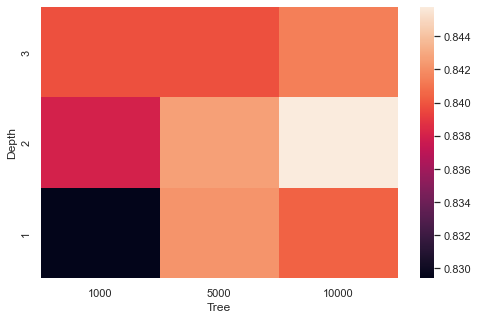

In [45]:
gini_10000 = {1000:[0.8294,0.8380,0.8398],5000:[0.8422,0.8426,0.8398],10000:[0.8404,0.8458,0.8414]}
sns4 = pd.DataFrame(gini_10000,index=pd.RangeIndex(start=1, stop=4, name='index'))
# use.corr()
fig, ax = plt.subplots(figsize=(8,5))         # Sample figsize in inches
sns.heatmap(sns4, ax=ax)
ax.set(xlabel='Tree', ylabel='Depth')
ax.invert_yaxis()

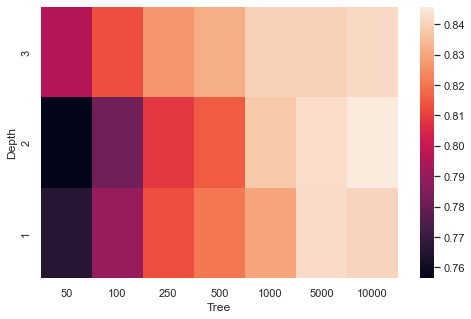

In [44]:
overall = {50:[0.7658,0.7564,0.7962],100:[0.7904,0.7824,0.813,],250:[0.8128,0.8086,0.8264],500:[0.8204,0.8154,0.8316],
       1000:[0.8294,0.8380,0.8398],5000:[0.8422,0.8426,0.8398],10000:[0.8404,0.8458,0.8414]}
sns1 = pd.DataFrame(overall,index=pd.RangeIndex(start=1, stop=4, name='index'))
# use.corr()
fig, ax = plt.subplots(figsize=(8,5))         # Sample figsize in inches
sns.heatmap(sns1, ax=ax)
ax.set(xlabel='Tree', ylabel='Depth')
ax.invert_yaxis()

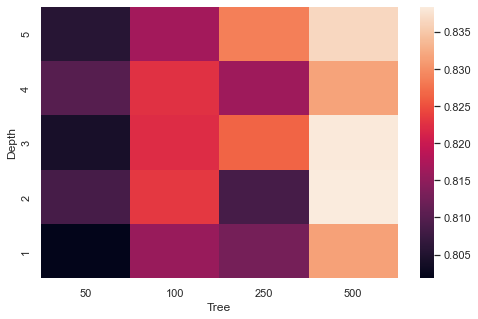

In [43]:
gini_500 = {50:[0.8018,0.8086,0.8042,0.8100,0.8056],100:[0.8158,0.8232,0.8222,0.8226,0.8166],
            250:[0.8128,0.8086,0.8264,0.8162,0.8286],500:[0.8314,0.8384,0.8382,0.8316,0.8364]}
gini_500_df = pd.DataFrame(gini_500,index=pd.RangeIndex(start=1, stop=6, name='index'))
fig, ax = plt.subplots(figsize=(8,5))         # Sample figsize in inches
sns.heatmap(gini_500_df, ax=ax)
ax.set(xlabel='Tree', ylabel='Depth')
ax.invert_yaxis()

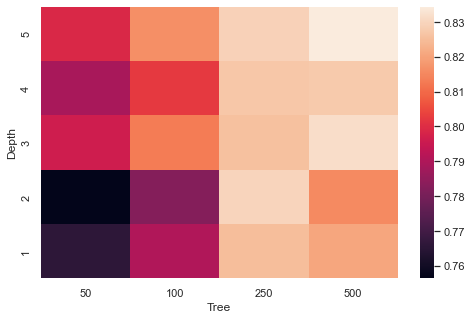

In [42]:
entropy_500 = {50:[0.7658,0.7564,0.7962,0.7888,0.7990],100:[0.7904,0.7824,0.813,0.8022,0.8162],
            250:[0.8250,0.8298,0.8258,0.8268,0.8290],500:[0.8204,0.8154,0.8316,0.8274,0.8344]}
entropy_500_df = pd.DataFrame(entropy_500,index=pd.RangeIndex(start=1, stop=6, name='index'))
fig, ax = plt.subplots(figsize=(8,5))         # Sample figsize in inches
sns.heatmap(entropy_500_df, ax=ax)
ax.set(xlabel='Tree', ylabel='Depth')
ax.invert_yaxis()

------------------------------
Best accuracy : 0.8453999999999999
Best combinations : (5000, 3)


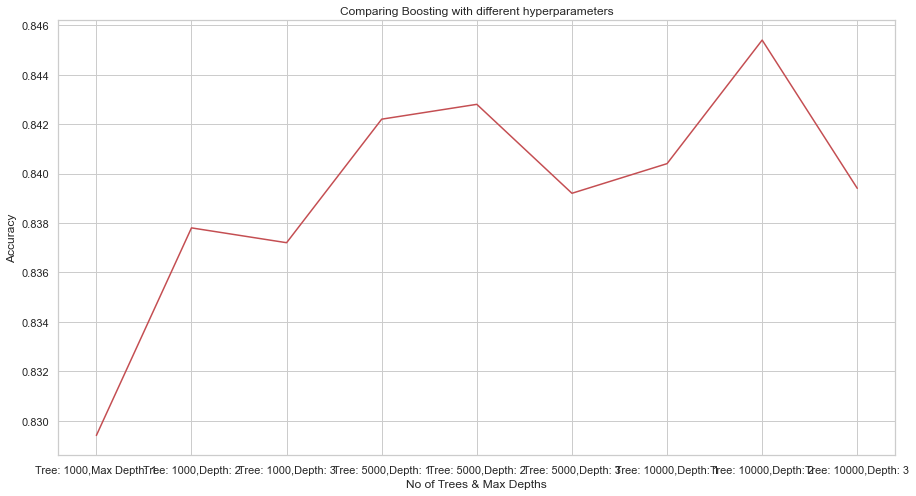

In [15]:
ac=list()
pre=list()
rec=list()
fsco=list()
for i in range(9):
    sum_=0
    for j in range(5):
        sum_+=results[i][j].iloc[2][2]
    avg_=sum_/5
    ac.append(avg_)
number = []
depths = [1,2,3,4,5]
for num_tree in num_trees:
    for depth in depths:
        number.append((num_tree,depth))
acc_dict={}
for i in range(9):
    acc_dict[number[i]]=ac[i]
max_=0
for i in acc_dict.keys():
    if acc_dict[i]>max_:
        max_=acc_dict[i]
        comb=i        
print('------------------------------')
print('Best accuracy :',max_)
print('Best combinations :',comb)

x_axis=['Tree: 1000,Max Depth: 1',
 'Tree: 1000,Depth: 2',
 'Tree: 1000,Depth: 3',
 'Tree: 5000,Depth: 1',
 'Tree: 5000,Depth: 2',
 'Tree: 5000,Depth: 3',
 'Tree: 10000,Depth: 1',
 'Tree: 10000,Depth: 2',
 'Tree: 10000,Depth: 3']
x = x_axis
y = list(acc_dict.values())
plt.figure(figsize=(15,8))
plt.title('Comparing Boosting with different hyperparameters')
plt.xlabel('No of Trees & Max Depths')
plt.ylabel('Accuracy')
plt.plot(x,y,'r-')
plt.show()

### Most common words in misclassifications

In [16]:
train = pd.read_csv("movie_review_train.csv")
test = pd.read_csv("movie_review_test.csv")
    
Y_train = np.array(train.sentiment)
Y_train[Y_train=='positive'] = 1
Y_train[Y_train=='negative'] = -1
Y_train = Y_train.astype('int')
    
Y_test = np.array(test.sentiment)
Y_test[Y_test=='positive'] = 1
Y_test[Y_test=='negative'] = -1
Y_test = Y_test.astype('int')

In [17]:
# Indexes of misclassified words
wrong_idx = [w for w in range(len(y_pred)) if y_pred[w] != Y_test[w]]

# Indexes of correctly classified words
correct_idx = [w for w in range(len(y_pred)) if y_pred[w] == Y_test[w]]

# lists of the raw samples, one for correct and one for wrong.
raw_wrong_samples = [test.review[i] for i in wrong_idx]
raw_correct_samples = [test.review[i] for i in correct_idx]

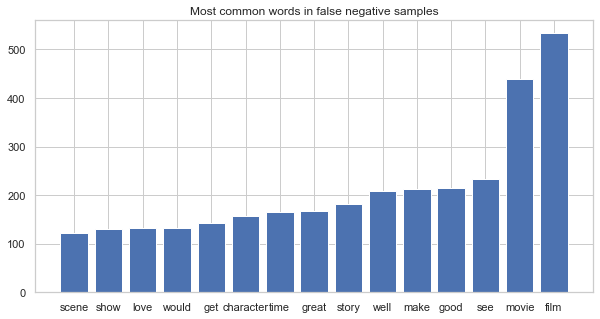

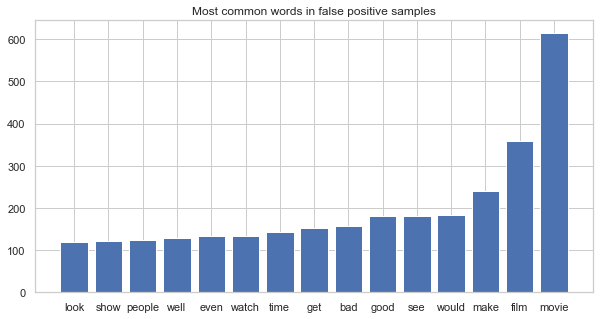

In [18]:
# find the most common words in misclassified samples
# map the feature value
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt


# Function that counts words in a list of reviews
# and then sorts from most frequent to least.
# This will be applied to our lists of correctly and incorrectly
# classified reviews, so we can see the most frequent words in each.
def sorted_count(reviews):
    words = []
    for review in reviews:
        tokens = word_tokenize(review)
        for word in tokens:
            words.append(word)
    unique, counts = np.unique(np.array(words), return_counts=True)
    sorted_indices = np.argsort(counts)
    sorted_unique = unique[sorted_indices]
    sorted_counts = counts[sorted_indices]
    
    return sorted_unique, sorted_counts
    
fn_samples = [X_test[i] for i in wrong_idx if Y_test[i] == 1]
fp_samples = [X_test[i] for i in wrong_idx if Y_test[i] == -1]

fn_unique, fn_counts = sorted_count(fn_samples)
fp_unique, fp_counts = sorted_count(fp_samples)

plt.figure(figsize=(10, 5))
plt.title('Most common words in false negative samples')
plt.bar(fn_unique[-15:], fn_counts[-15:])
plt.show()

plt.figure(figsize=(10, 5))
plt.title('Most common words in false positive samples')
plt.bar(fp_unique[-15:], fp_counts[-15:])
plt.show()

In [19]:
import en_core_web_sm
import spacy
nlp = en_core_web_sm.load()
test = pd.read_csv(r'movie_review_test.csv')

C:\Users\lolon\anaconda3\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [20]:
# Helper functions for results analysis

count = lambda data, to_count: sum([1 for x in data if x in to_count])

# 1. Number of tokens
def get_mean_len(X, Y, indices, sent):
    samples = [X[i] for i in indices if Y[i] == sent]
    samples = [nlp(review) for review in samples]
    return sum(len(review) for review in samples) / len(samples)

# 2. Number of punctuations
def get_mean_punc(X, Y, indices, sent):
    samples = [X[i] for i in indices if Y[i] == sent]
    c = 0
    ttl_len = 0
    for i in range(len(samples)):
        tokens = nlp(samples[i])
        c += count(samples[i], set(string.punctuation))
        ttl_len += len(tokens)
    return (c / ttl_len) * 100

# 3. Number of words trimmed
def get_mean_trim(X, X_trim, Y, indices, sent):
    samples = [X[i] for i in indices if Y[i] == sent]
    trim_samples = [X_trim[i] for i in indices if Y[i] == sent]
    return (sum(((len(samples[i].split()) - len(trim_samples[i].split()))/len(samples[i].split())) \
               for i in range(len(samples))) / len(samples))*100


# 4. Number of adjectives
def get_mean_pos(X, Y, indices, sent, pos):
    samples = [X[i] for i in indices if Y[i] == sent]
    count = 0
    ttl_len = 0
    for i in range(len(samples)):
        tokens = nlp(samples[i])
        count += len([token for token in tokens if token.pos_ == pos])
        ttl_len += len(tokens)
    return (count / ttl_len)*100
    #return round(count/len(samples), 2)

# 5. Number of negation words
def get_mean_dep(X, Y, indices, sent, dep):
    samples = [X[i] for i in indices if Y[i] == sent]
    count = 0
    ttl_len = 0
    
    for i in range(len(samples)):
        tokens = nlp(samples[i])
        count += len([token for token in tokens if token.dep_ == dep])
        ttl_len += len(tokens)
        
    return (count/ttl_len)*100


## 3.3 Using boosting classifier with gini criteria, 10000 trees, 1 depth

In [29]:
clf=BoostingClassifier(n_clf=10000,  max_depth=1, criterion="gini", splitter='best')
clf.fit(X_train,Y_train)
y_pred= clf.predict(X_test)

acc=accuracy_score(Y_test,y_pred)
print("Accuracy :",acc)
classificationReport = classification_report(Y_test, y_pred)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy : 0.854


In [30]:
cus_pred = y_pred

cus_wrong_idx = [w for w in range(len(cus_pred)) if cus_pred[w] != Y_test[w]]
cus_correct_idx = [w for w in range(len(cus_pred)) if cus_pred[w] == Y_test[w]]

cus_raw_wrong_samples = [test.review[i] for i in cus_wrong_idx]
cus_raw_correct_samples = [test.review[i] for i in cus_correct_idx]

# 1. Number of tokens
cus_fn_mean_len = get_mean_len(X_test, Y_test, cus_wrong_idx, 1)
cus_fp_mean_len = get_mean_len(X_test, Y_test, cus_wrong_idx, -1)
cus_tn_mean_len = get_mean_len(X_test, Y_test, cus_correct_idx, -1)
cus_tp_mean_len = get_mean_len(X_test, Y_test, cus_correct_idx, 1)

# 2. Number of punctuations
cus_fn_mean_punc = get_mean_punc(test.review, Y_test, cus_wrong_idx, 1)
cus_fp_mean_punc = get_mean_punc(test.review, Y_test, cus_wrong_idx, -1)
cus_tn_mean_punc = get_mean_punc(test.review, Y_test, cus_correct_idx, -1)
cus_tp_mean_punc = get_mean_punc(test.review, Y_test, cus_correct_idx, 1)

# 3. Number of negation words
cus_fn_mean_neg = get_mean_dep(test.review, Y_test, cus_wrong_idx, 1, 'neg')
cus_fp_mean_neg = get_mean_dep(test.review, Y_test, cus_wrong_idx, -1, 'neg')
cus_tn_mean_neg = get_mean_dep(test.review, Y_test, cus_correct_idx, -1, 'neg')
cus_tp_mean_neg = get_mean_dep(test.review, Y_test, cus_correct_idx, 1, 'neg')

# 4. Number of adjectives
cus_fn_mean_adj = get_mean_pos(test.review, Y_test, cus_wrong_idx, 1, 'ADJ')
cus_fp_mean_adj = get_mean_pos(test.review, Y_test, cus_wrong_idx, -1, 'ADJ')
cus_tn_mean_adj = get_mean_pos(test.review, Y_test, cus_correct_idx, -1, 'ADJ')
cus_tp_mean_adj = get_mean_pos(test.review, Y_test, cus_correct_idx, 1, 'ADJ')

# 5. Number of words trimmed
cus_fn_mean_trim = get_mean_trim(test.review, X_test, Y_test, cus_wrong_idx, 1)
cus_fp_mean_trim = get_mean_trim(test.review, X_test, Y_test, cus_wrong_idx, -1)
cus_tn_mean_trim = get_mean_trim(test.review, X_test, Y_test, cus_correct_idx, -1)
cus_tp_mean_trim = get_mean_trim(test.review, X_test, Y_test, cus_correct_idx, 1)

# Structure: FP, TP, FN, TN
labels = ['False Positive', 'True Positive', 'False Negative', 'True Negative']
cus_analysis = {'Punctuations': [cus_fp_mean_punc, cus_tp_mean_punc, cus_fn_mean_punc, cus_tn_mean_punc],
            'Adjectives': [cus_fp_mean_adj, cus_tp_mean_adj, cus_fn_mean_adj, cus_tn_mean_adj],
            'Negation Words': [cus_fp_mean_neg, cus_tp_mean_neg, cus_fn_mean_neg, cus_tn_mean_neg],
            'Tokens': [cus_fp_mean_len, cus_tp_mean_len, cus_fn_mean_len, cus_tn_mean_len],
            'Words Trimmed':  [cus_fp_mean_trim, cus_tp_mean_trim, cus_fn_mean_trim, cus_tn_mean_trim]
}

cus_analysis_df = pd.DataFrame(cus_analysis, index=labels)

cus_analysis_df.style.background_gradient(axis=0)

,Punctuations,Adjectives,Negation Words,Tokens,Words Trimmed
False Positive,21.010206,7.316518,1.020607,109.756757,54.769907
True Positive,18.796197,7.643336,0.881944,112.099849,54.695030
False Negative,18.755010,7.033565,1.035168,104.787037,55.166033
True Negative,19.865290,7.304152,1.216278,109.825806,54.487983


## 3.4 Using boosting classifier with entropy criteria, 10000 trees, 1 depth

In [31]:
clf=BoostingClassifier(n_clf=10000,  max_depth=1, criterion="entropy", splitter='best')
clf.fit(X_train,Y_train)
y_pred= clf.predict(X_test)

acc=accuracy_score(Y_test,y_pred)
print("Accuracy :",acc)
classificationReport = classification_report(Y_test, y_pred)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Accuracy : 0.8486666666666667


In [32]:
ent_pred = y_pred

ent_wrong_idx = [w for w in range(len(ent_pred)) if ent_pred[w] != Y_test[w]]
ent_correct_idx = [w for w in range(len(ent_pred)) if ent_pred[w] == Y_test[w]]

ent_raw_wrong_samples = [test.review[i] for i in ent_wrong_idx]
ent_raw_correct_samples = [test.review[i] for i in ent_correct_idx]

# 1. Number of tokens
ent_fn_mean_len = get_mean_len(X_test, Y_test, ent_wrong_idx, 1)
ent_fp_mean_len = get_mean_len(X_test, Y_test, ent_wrong_idx, -1)
ent_tn_mean_len = get_mean_len(X_test, Y_test, ent_correct_idx, -1)
ent_tp_mean_len = get_mean_len(X_test, Y_test, ent_correct_idx, 1)

# 2. Number of punctuations
ent_fn_mean_punc = get_mean_punc(test.review, Y_test, ent_wrong_idx, 1)
ent_fp_mean_punc = get_mean_punc(test.review, Y_test, ent_wrong_idx, -1)
ent_tn_mean_punc = get_mean_punc(test.review, Y_test, ent_correct_idx, -1)
ent_tp_mean_punc = get_mean_punc(test.review, Y_test, ent_correct_idx, 1)

# 3. Number of negation words
ent_fn_mean_neg = get_mean_dep(test.review, Y_test, ent_wrong_idx, 1, 'neg')
ent_fp_mean_neg = get_mean_dep(test.review, Y_test, ent_wrong_idx, -1, 'neg')
ent_tn_mean_neg = get_mean_dep(test.review, Y_test, ent_correct_idx, -1, 'neg')
ent_tp_mean_neg = get_mean_dep(test.review, Y_test, ent_correct_idx, 1, 'neg')

# 4. Number of adjectives
ent_fn_mean_adj = get_mean_pos(test.review, Y_test, ent_wrong_idx, 1, 'ADJ')
ent_fp_mean_adj = get_mean_pos(test.review, Y_test, ent_wrong_idx, -1, 'ADJ')
ent_tn_mean_adj = get_mean_pos(test.review, Y_test, ent_correct_idx, -1, 'ADJ')
ent_tp_mean_adj = get_mean_pos(test.review, Y_test, ent_correct_idx, 1, 'ADJ')

# 5. Number of words trimmed
ent_fn_mean_trim = get_mean_trim(test.review, X_test, Y_test, ent_wrong_idx, 1)
ent_fp_mean_trim = get_mean_trim(test.review, X_test, Y_test, ent_wrong_idx, -1)
ent_tn_mean_trim = get_mean_trim(test.review, X_test, Y_test, ent_correct_idx, -1)
ent_tp_mean_trim = get_mean_trim(test.review, X_test, Y_test, ent_correct_idx, 1)

# Structure: FP, TP, FN, TN
labels = ['False Positive', 'True Positive', 'False Negative', 'True Negative']
ent_analysis = {'Punctuations': [ent_fp_mean_punc, ent_tp_mean_punc, ent_fn_mean_punc, ent_tn_mean_punc],
            'Adjectives': [ent_fp_mean_adj, ent_tp_mean_adj, ent_fn_mean_adj, ent_tn_mean_adj],
            'Negation Words': [ent_fp_mean_neg, ent_tp_mean_neg, ent_fn_mean_neg, ent_tn_mean_neg],
            'Tokens': [ent_fp_mean_len, ent_tp_mean_len, ent_fn_mean_len, ent_tn_mean_len],
            'Words Trimmed':  [ent_fp_mean_trim, ent_tp_mean_trim, ent_fn_mean_trim, ent_tn_mean_trim]
}

ent_analysis_df = pd.DataFrame(ent_analysis, index=labels)

ent_analysis_df.style.background_gradient(axis=0)

,Punctuations,Adjectives,Negation Words,Tokens,Words Trimmed
False Positive,20.695971,7.416030,1.039921,109.222222,54.735799
True Positive,18.803632,7.685594,0.874915,111.471927,54.662600
False Negative,18.712511,6.814383,1.068537,108.681818,55.351752
True Negative,19.915602,7.284993,1.214264,109.928339,54.491728


# 4. Summarising results of different criterion

## 4.1 Average percentage of punctuations in reviews (by classification result)

<Figure size 432x288 with 0 Axes>

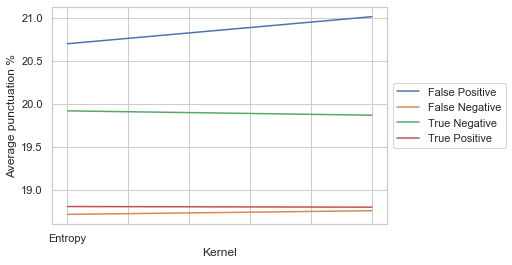

In [33]:
# for punctuations
criteria = ['Entropy','Gini']

characteristics = 'Punctuations'

punctuations = {'False Positive': [ent_analysis_df[characteristics]['False Positive'],
                          cus_analysis_df[characteristics]['False Positive']],
        'False Negative': [ent_analysis_df[characteristics]['False Negative'],
                          cus_analysis_df[characteristics]['False Negative']],
        'True Negative': [ent_analysis_df[characteristics]['True Negative'],
                          cus_analysis_df[characteristics]['True Negative']],
        'True Positive': [ent_analysis_df[characteristics]['True Positive'],
                          cus_analysis_df[characteristics]['True Positive']],
}

punctuations_df = pd.DataFrame(punctuations, index = criteria)
punc_plot = plt.figure()
punctuations_df.plot(xlabel='Kernel', 
                     ylabel='Average punctuation %')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## 4.2 Average percentage of adjectives in reviews (by classification result)

<Figure size 432x288 with 0 Axes>

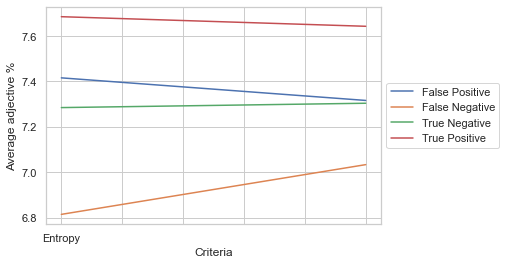

In [34]:
# for adjectives
criteria = ['Entropy','Gini']

characteristics = 'Adjectives'

adj = {'False Positive': [ent_analysis_df[characteristics]['False Positive'],
                          cus_analysis_df[characteristics]['False Positive']],
        'False Negative': [ent_analysis_df[characteristics]['False Negative'],
                          cus_analysis_df[characteristics]['False Negative']],
        'True Negative': [ent_analysis_df[characteristics]['True Negative'],
                          cus_analysis_df[characteristics]['True Negative']],
        'True Positive': [ent_analysis_df[characteristics]['True Positive'],
                          cus_analysis_df[characteristics]['True Positive']],
}

adj_df = pd.DataFrame(adj, index = criteria)
adj_plt = plt.figure()
adj_df.plot(xlabel='Criteria', 
            ylabel='Average adjective %')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## 4.3 Average percentage of negation words in reviews (by classification result)

<Figure size 432x288 with 0 Axes>

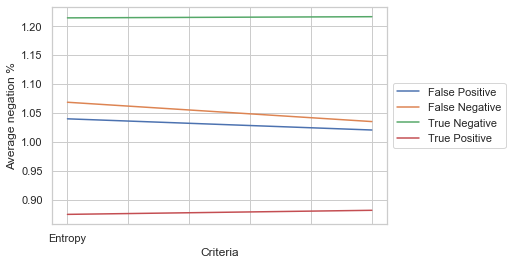

In [35]:
# for negative words
criteria = ['Entropy','Gini']

characteristics = 'Negation Words'

neg = {'False Positive': [ent_analysis_df[characteristics]['False Positive'],
                          cus_analysis_df[characteristics]['False Positive']],
        'False Negative': [ent_analysis_df[characteristics]['False Negative'],
                          cus_analysis_df[characteristics]['False Negative']],
        'True Negative': [ent_analysis_df[characteristics]['True Negative'],
                          cus_analysis_df[characteristics]['True Negative']],
        'True Positive': [ent_analysis_df[characteristics]['True Positive'],
                          cus_analysis_df[characteristics]['True Positive']],
}

neg_df = pd.DataFrame(neg, index = criteria)
neg_plt = plt.figure()
neg_df.plot(xlabel='Criteria', 
            ylabel='Average negation %')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## 4.4 Average length of review (by classification result)

<Figure size 432x288 with 0 Axes>

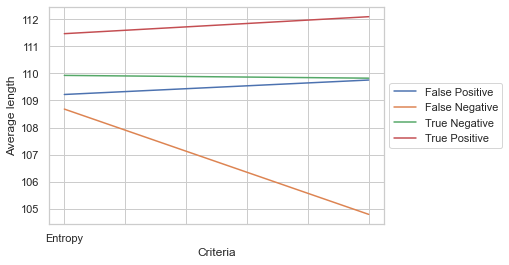

In [36]:
# for average length
criteria = ['Entropy','Gini']

characteristics = 'Tokens'

length = {'False Positive': [ent_analysis_df[characteristics]['False Positive'],
                          cus_analysis_df[characteristics]['False Positive']],
        'False Negative': [ent_analysis_df[characteristics]['False Negative'],
                          cus_analysis_df[characteristics]['False Negative']],
        'True Negative': [ent_analysis_df[characteristics]['True Negative'],
                          cus_analysis_df[characteristics]['True Negative']],
        'True Positive': [ent_analysis_df[characteristics]['True Positive'],
                          cus_analysis_df[characteristics]['True Positive']],
}

length_df = pd.DataFrame(length, index = criteria)
length_plt = plt.figure()
length_df.plot(xlabel='Criteria', 
            ylabel='Average length')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## 4.5 Average percentage of words trimmed during data preprocessing (by classification result)

<Figure size 432x288 with 0 Axes>

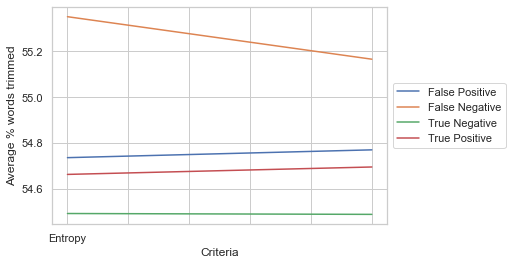

In [37]:
# for words trimmed
criteria = ['Entropy','Gini']

characteristics = 'Words Trimmed'

trim = {'False Positive': [ent_analysis_df[characteristics]['False Positive'],
                          cus_analysis_df[characteristics]['False Positive']],
        'False Negative': [ent_analysis_df[characteristics]['False Negative'],
                          cus_analysis_df[characteristics]['False Negative']],
        'True Negative': [ent_analysis_df[characteristics]['True Negative'],
                          cus_analysis_df[characteristics]['True Negative']],
        'True Positive': [ent_analysis_df[characteristics]['True Positive'],
                          cus_analysis_df[characteristics]['True Positive']],
}

trim_df = pd.DataFrame(trim, index = criteria)
trim_plt = plt.figure()
trim_df.plot(xlabel='Criteria', 
            ylabel='Average % words trimmed')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))